# Introduction to indirect multiple shooting: the Bang-Singular-Bang case on a turnpike problem 

* Author: Olivier Cots
* Date: March 2021

------

## I) Description of the optimal control problem

We consider the following optimal control problem:

$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \int_0^{t_f} x^2(t) \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) = f(x(t), u(t)) := \displaystyle u(t), \quad  |u(t)| \le 1, \quad t \in [0, t_f] \text{ a.e.},    \\[1.0em]
        x(0) = 1, \quad x(t_f) = 1/2.
    \end{array}
    \right. 
$$

To this optimal control problem is associated the stationnary optimization problem

$$
    \min_{(x, u)} \{~ x^2 ~ | ~  (x, u) \in \mathrm{R} \times [-1, 1],~ f(x,u) = u = 0\}.
$$

The static solution is thus $(x^*, u^*) = (0, 0)$. This solution may be seen as the static pair $(x, u)$ which minimizes the cost $J(u)$ under
the constraint $u \in [-1, 1]$.
It is well known that this problem is what we call a *turnpike* optimal control problem.
Hence, if the final time $t_f$ is long enough the solution is of the following form: 
starting from $x(0)=1$, reach as fast as possible the static solution, stay at the static solution as long as possible before reaching
the target $x(t_f)=1/2$. In this case, the optimal control would be

$$
    u(t) = \left\{ 
    \begin{array}{lll}
        -1            & \text{if} & t \in [0, t_1],     \\[0.5em]
        \phantom{-}0  & \text{if} & t \in (t_1, t_2],   \\[0.5em]
        +1            & \text{if} & t \in (t_2, t_f],
    \end{array}
    \right. 
$$

with $0 < t_1 < t_2 < t_f$. We say that the control is *Bang-Singular-Bang*. A Bang arc corresponds to $u \in \{-1, 1\}$ while a singular control corresponds to $u \in (-1, 1)$. Since the optimal control law is discontinuous, then to solve this optimal control problem by indirect methods and find the *switching times* $t_1$ and $t_2$, we need to implement what we call a *multiple shooting method*. In the next section we introduce a regularization technique to force the control to be in the set $(-1,1)$ and to be smooth. In this context, we will be able to implement a simple shooting method and determine the structure of the optimal control law. Thanks to the simple shooting method, we will have the structure of the optimal control law together with an approximation of the switching times that we will use as initial guess for the multiple shooting method that we present in the last section.

<div class="alert alert-warning">

**Main goal**

Find the switching times $t_1$ and $t_2$ by multiple shooting.
    
</div>

Steps:

1. Regularize the problem and solve the regularized problem by simple shooting.
2. Determine the structure of the non-regularized optimal control problem, that is the structure Bang-Singular-Bang, and find a good approximation of the switching times and of the initial co-vector.
3. Solve the non-regularized optimal control problem by multiple shooting.

**_Remark 1._** See this [page](https://ct.gitlabpages.inria.fr/gallery/shooting_tutorials/simple_shooting_general.html) for a general presentation of the simple shooting method.

**_Remark 2._** In this particular example, the singular control does not depend on the costate $p$ since it is constant. This happens in low dimension. This could be taken into consideration to simplify the definition of the multiple shooting method. However, to stay general, we will not consider this particular property in this notebook.  


## II) Regularization and simple shooting

We make the following regularization:

$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \int_0^{t_f} (x^2(t) - \varepsilon\ln(1-u^2(t))) \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) = f(x(t), u(t)) := \displaystyle u(t), \quad  |u(t)| \le 1, \quad t \in [0, t_f] \text{ a.e.},    \\[1.0em]
        x(0) = 1, \quad x(t_f) = 1/2.
    \end{array}
    \right. 
$$

Our goal is to determine the structure of the optimal control problem when $(\varepsilon, t_f) = (0, 2)$. The problem is simpler to solver when $\varepsilon$ is bigger and $t_f$ is smaller. It is also smooth whenever $\varepsilon>0$. Hence, we will start by solving the problem for $(\varepsilon, t_f) = (1, 1)$. In a second step, we will decrease the *penalization term* $\varepsilon$ and in a final step, we will increase the final time $t_f$ to the final value $2$.


### Preliminaries

In [1]:
# import packages
import nutopy as nt
import nutopy.tools as tools
import nutopy.ocp as ocp
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 150

In [2]:
# Finite differences function for scalar functionnal
# Return f'(x).dx
def finite_diff(fun, x, dx, *args, **kwargs):
    v_eps = np.finfo(float).eps
    t = np.sqrt(v_eps) * np.sqrt(np.maximum(1.0, np.abs(x))) / np.sqrt(np.maximum(1.0, np.abs(dx)))
    j = (fun(x + t*dx, *args, **kwargs) - fun(x, *args, **kwargs)) / t
    return j

In [3]:
# Parameters

t0        = 0.0
x0        = np.array([1.0])
xf_target = np.array([0.5])

e_init    = 1.0
e_final   = 0.002 #

tf_init   = 1.0 # With this value the problem is simpler to solver since the trajectory stay 
                # less time around the static solution
tf_final  = 2.0

### Maximized Hamiltonian and its derivatives

The pseudo-Hamiltonian is (in the normal case)

$$
    H(x,p,u,\varepsilon) = pu - x^2 + \varepsilon ln(1-u^2).
$$

Note that we put the parameter $\varepsilon$ into the arguments of the pseudo-Hamiltonian since we will vary it.

<div class="alert alert-info">

**_Question 1:_**
    
Give the maximizing control $u[p, \varepsilon]$, that is the control in feedback form solution of the maximization condition.
    
</div>

**Answer 1:**
$$
 \nabla_{u} H(x, p, u, \epsilon) = 0
$$
donc
$$
p - 2 \epsilon \frac{u}{1 - u^2} = 0
$$
donc 
$$
p u^2 + 2 \epsilon u - p = 0
$$
donc
$$
u_1 = \frac{\sqrt{\epsilon^2 + p^2} - \epsilon}{p}
$$

$$
u_2 = \frac{-\sqrt{\epsilon^2 + p^2} - \epsilon}{p}
$$
or $|u| \leq 1$ donc 
$$
u[p, \varepsilon] = \frac{\sqrt{\epsilon^2 + p^2} - \epsilon}{p}
$$

<div class="alert alert-info">

**_Question 2:_**
    
Complete the code of the maximizing control $u[p, \varepsilon]$ and its derivative with respect to $p$, that is $\frac{\partial u}{\partial p}[p, \varepsilon]$.
    
</div>

on a
$$
\frac{\partial u}{\partial p}[p, \varepsilon] = \frac{2}{\sqrt{p^2 + \epsilon^2}} - \frac{\sqrt{p^2 + \epsilon^2} - \epsilon}{p^2}
$$

In [4]:
# ----------------------------
# Answer 2 to complete here
# ----------------------------
#
# Control in feedback form u[p,e] and its partial derivative wrt. p.
#
@tools.vectorize(vvars=(1,))
def ufun(p, e):
    u = (np.sqrt(e**2 + p**2) - e) / p
    return u

def dufun(p, e):
    du = (2 / np.sqrt(p**2 + e**2)) - ((np.sqrt(p**2 + e**2) - e) / (p**2))
    return du

We give next the maximized Hamiltonian with its derivatives. This permits us to define the flow of the associated Hamiltonian vector field.

In [5]:
# Definition of the maximized Hamiltonian and its derivatives
# The second derivative d2hfun is computed by finite differences for a part
def dhfun(t, x, dx, p, dp, e):
    # dh = dh_x dx + dh_p dp
    u  = ufun(p, e)
    du = dufun(p, e)
    hd = (u+p*du+2.0*e*u*du/(u**2-1.0))*dp - 2.0*x*dx
    return hd

def d2hfun(t, x, dx, d2x, p, dp, d2p, e):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    d2h_xx = -2.0*dx*d2x # dh_xx dx d2x
    dh_p   = lambda p: dhfun(t, x, 0.0, p, dp, e) # dh_px = 0 so we can put dx = 0
    d2h_pp = finite_diff(dh_p, p, d2p) # dh_pp dp d2p
    hdd    = d2h_xx + d2h_pp
    return hdd

@tools.tensorize(dhfun, d2hfun, tvars=(2, 3))
def hfun(t, x, p, e):
    u = ufun(p, e)
    h = p*u - x**2 + e*(np.log(1.0-u**2))
    return h

h = ocp.Hamiltonian(hfun)   # The Hamiltonian object

f = ocp.Flow(h)             # The flow associated to the Hamiltonian object is 
                            # the exponential mapping with its derivative
                            # that can be used to define the Jacobian of the 
                            # shooting function

### Shooting function and its derivative

The shooting function is

$$
    S(p_0, \varepsilon, t_f) = \pi_x(z(t_f, 1, p_0, \varepsilon)) - 1/2,
$$

where $z(t_f, x_0, p_0, \varepsilon)$ is the solution of the associated Hamiltonian system 
with the initial condition $z(0) = (x_0, p_0)$. Note that the Hamiltonian system depends on $\varepsilon$. We put $\varepsilon$ and $t_f$ into 
the arguments of the shooting function since we will vary them.

<div class="alert alert-warning">

**Procedure**

First solve $S=0$ for $(\varepsilon, t_f) = (1,1)$ then decrease $\varepsilon$ to $0.01$, and finish by increasing $t_f$ to 2.
    
</div>

<div class="alert alert-info">

**_Question 3:_**
    
Complete the code of the shooting function.
    
</div>

In [6]:
# ----------------------------
# Answer 3 to complete here
# ----------------------------
#
# Definition of the shooting function and its partial derivative wrt. p0 against the vector dp0
#
def shoot(p0, e, tf):
    xf, pf = f(t0, x0, p0, tf, e)
    s = xf - xf_target
    return s

In [7]:
def dshoot(p0, dp0, e, tf):
    (xf, dxf), _ = f(t0, x0, (p0, dp0), tf, e)
    ds = dxf
    return ds

shoot = nt.tools.tensorize(dshoot, tvars=(1,))(shoot)

In [8]:
# Function to plot the solution
def plotSolution(p0, e, tf):

    N      = 200
    tspan  = list(np.linspace(t0, tf, N+1))
    xf, pf = f(t0, x0, p0, tspan, e)
    u      = ufun(pf, e)

    fig = plt.figure()
    ax  = fig.add_subplot(511); ax.plot(tspan, xf); ax.set_xlabel('t'); ax.set_ylabel('$x$'); ax.axhline(0, color='k')
    ax  = fig.add_subplot(513); ax.plot(tspan, pf); ax.set_xlabel('t'); ax.set_ylabel('$p$'); ax.axhline(0, color='k')
    ax  = fig.add_subplot(515); ax.plot(tspan,  u); ax.set_xlabel('t'); ax.set_ylabel('$u$'); ax.axhline(0, color='k')

### Resolution of the regularized problem

In [9]:
# Shooting for (tf, e) = (tf_init, e_init)
p0_guess = np.array([0.1])
nlefun   = lambda p0: shoot(p0, e_init, tf_init)
sol_nle  = nt.nle.solve(nlefun, p0_guess, df=nlefun)


     Calls  |f(x)|                 |x|
 
         1  9.225527956247912e-01  1.000000000000000e-01
         2  1.328510078588877e-01  2.933843267532438e+00
         3  7.295873948535520e-02  2.551952341569125e+00
         4  3.048709526028692e-02  2.086745707460550e+00
         5  4.420525623099247e-03  2.223849332798960e+00
         6  2.283581455932993e-04  2.206487218925520e+00
         7  1.831091421822251e-06  2.205541459924003e+00
         8  7.509125543592177e-10  2.205548983174078e+00
         9  2.720046410331634e-15  2.205548980090132e+00

 Results of the nle solver method:

 xsol    =  [-2.20554898]
 f(xsol) =  [-2.72004641e-15]
 nfev    =  9
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.



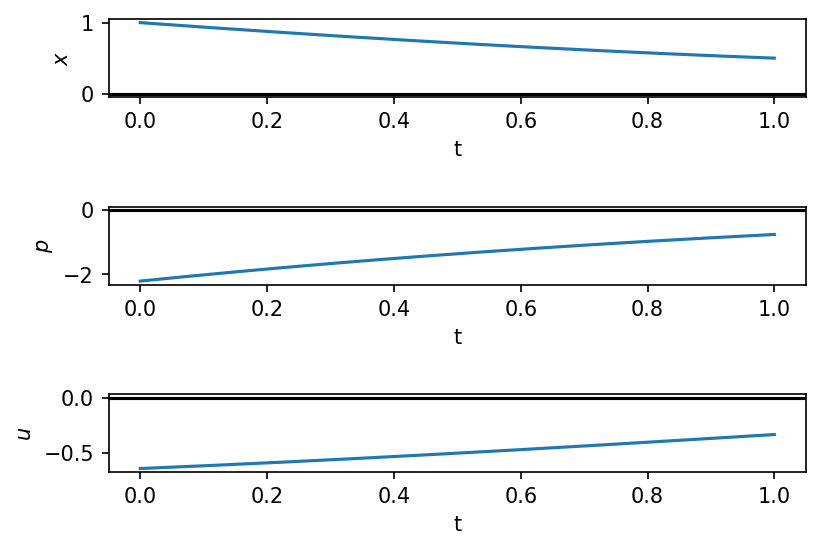

In [10]:
# Plot solution for (tf, e) = (tf_init, e_init)
plotSolution(sol_nle.x, e_init, tf_init)

In [11]:
# Definition of the homotopic function and its first order derivative
# This function is used to solve S=0 for different values of e=epsilon and tf.
def dhomfun(p0, dp0, e, de, tf, dtf):
    #
    (xf, dxf), (pf, dpf) = f(t0, x0, (p0, dp0), tf, e)    
    #
    s     = xf - xf_target
    #
    ds_p0 = dxf
    ds_tf = ufun(pf, e) * dtf # dS_tf dtf = u dtf
    #
    fun = lambda e: float(f(t0, x0, p0, tf, e)[0])
    ds_e = finite_diff(fun, e, de) # dS_e de
    #
    ds    = ds_p0 + ds_e + ds_tf
    return s, ds

@tools.tensorize(dhomfun, tvars=(1, 2, 3), full=True)
def homfun(p0, e, tf):
    xf, pf = f(t0, x0, p0, tf, e)  # We use the flow to get z(tf, x0, p0, e)
    s = xf - xf_target             # x(tf, x0, p0) - xf_target
    return s

In [12]:
# Making the penalization smaller: homotopy on e
p0         = sol_nle.x
sol_path_e = nt.path.solve(homfun, p0, e_init, e_final, args=tf_init, df=homfun)


     Calls  |f(x,pars)|     |x|                Homotopic param    Arclength s     det A(s)        Dot product                
 
         1  4.44089210e-16  2.20554898009e+00  1.00000000000e+00  0.00000000e+00 -3.99453522e-01  0.00000000e+00
         2  1.66533454e-16  2.19703976146e+00  9.93456169370e-01  1.07344549e-02 -4.02221726e-01  9.99999991e-01
         3  1.66533454e-16  2.18383044226e+00  9.83294248294e-01  2.74003108e-02 -4.06596256e-01  9.99999978e-01
         4  2.22044605e-16  2.16059423691e+00  9.65407769537e-01  5.67234650e-02 -4.14528889e-01  9.99999927e-01
         5  2.77555756e-16  2.11360816450e+00  9.29194613801e-01  1.16045332e-01 -4.31562403e-01  9.99999659e-01
         6  1.11022302e-16  2.04703149096e+00  8.77769927280e-01  2.00169958e-01 -4.58265795e-01  9.99999139e-01
         7  5.55111512e-16  1.92922310340e+00  7.86391713746e-01  3.49263248e-01 -5.14697419e-01  9.99996003e-01
         8  0.00000000e+00  1.80192922849e+00  6.86963230702e-01  5.10786587e-01

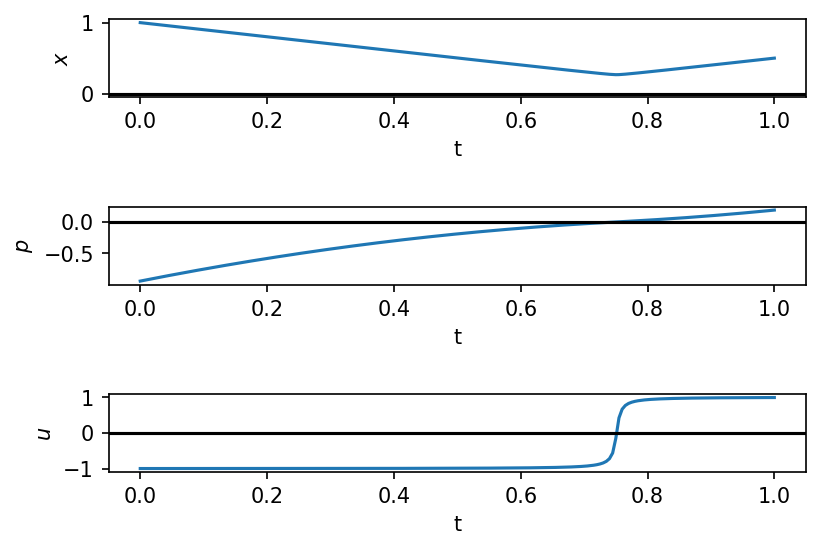

In [13]:
# Plot solution for (tf, e) = (tf_init, e_final)
plotSolution(sol_path_e.xf, e_final, tf_init)

In [14]:
# Making the time bigger: homotopy on tf
p0          = sol_path_e.xf                       # sol is coming from last homotopy
pathfun     = lambda p0, tf, e: homfun(p0, e, tf) # invert order of arguments
sol_path_tf = nt.path.solve(pathfun, p0, tf_init, tf_final, args=e_final, df=pathfun)


     Calls  |f(x,pars)|     |x|                Homotopic param    Arclength s     det A(s)        Dot product                
 
         1  9.43689571e-15  9.41628939496e-01  1.00000000000e+00  0.00000000e+00  4.01455512e+00  0.00000000e+00
         2  2.53130850e-14  9.44075168781e-01  1.00970881514e+00  1.00122571e-02  4.08611402e+00  9.99990246e-01
         3  4.16333634e-14  9.49430358432e-01  1.03162819520e+00  3.25764216e-02  4.25803269e+00  9.99950033e-01
         4  5.32907052e-15  9.58412814636e-01  1.07075346636e+00  7.27200944e-02  4.60588751e+00  9.99839533e-01
         5  4.04121181e-14  9.68386573648e-01  1.11854697738e+00  1.21544181e-01  5.12000171e+00  9.99758771e-01
         6  7.30526750e-14  9.78117250857e-01  1.17123591112e+00  1.75125431e-01  5.84153926e+00  9.99706304e-01
         7  1.44328993e-15  9.86553588115e-01  1.22405137184e+00  2.28611731e-01  6.80111084e+00  9.99707295e-01
         8  1.37667655e-14  9.93479494871e-01  1.27515652212e+00  2.80185207e-01

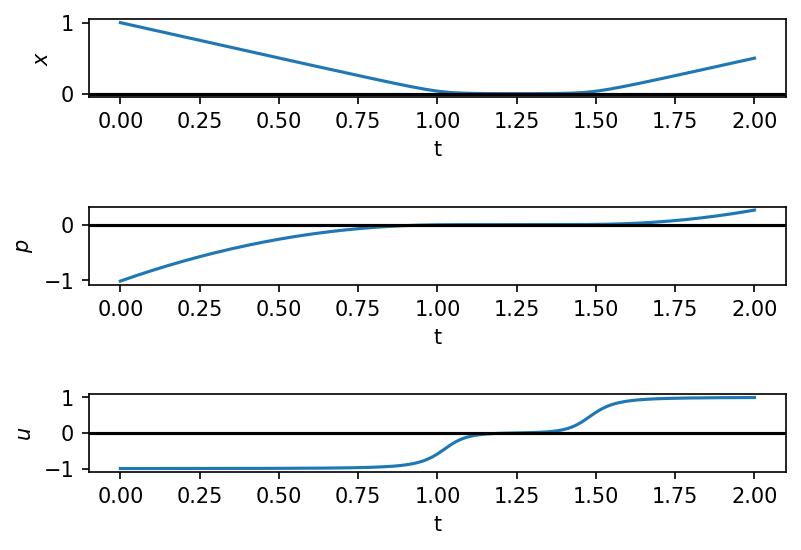

In [15]:
# Plot solution for (tf, e) = (tf_final, e_final)
plotSolution(sol_path_tf.xf, e_final, tf_final)

## III) Resolution of the optimal control problem by multiple shooting

We come back to the original optimal control problem:

$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \int_0^{t_f} x^2(t) \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) = f(x(t), u(t)) := \displaystyle u(t), \quad  |u(t)| \le 1, \quad t \in [0, t_f] \text{ a.e.},    \\[1.0em]
        x(0) = 1, \quad x(t_f) = 1/2.
    \end{array}
    \right. 
$$

We have determined that the optimal control follows the strategy:

$$
    u(t) = \left\{ 
    \begin{array}{lll}
        -1            & \text{if} & t \in [0, t_1],     \\[0.5em]
        \phantom{-}0  & \text{if} & t \in (t_1, t_2],   \\[0.5em]
        +1            & \text{if} & t \in (t_2, t_f],
    \end{array}
    \right. 
$$

with $0 < t_1 < t_2 < t_f=2$. 


<div class="alert alert-warning">

**Goal**

The goal is to find the values of the switching times $t_1$ and $t_2$ together with the initial covector $p_0$ (see Remark 2).
    
</div>

### Maximized Hamiltonian and its derivatives

We define first the three control laws $u \equiv \{-1, 0, 1\}$.

In [16]:
# Controls in feedback form
@tools.vectorize(vvars=(1, 2, 3))
def uplus(t, x, p):
    u = +1.0
    return u

@tools.vectorize(vvars=(1, 2, 3))
def uminus(t, x, p):
    u = -1.0
    return u

@tools.vectorize(vvars=(1, 2, 3))
def using(t, x, p):
    u = 0.0
    return u

The pseudo-Hamiltonian is

$$
    H(x,p,u) = pu - x^2.
$$

<div class="alert alert-info">

**_Question 4:_**
    
Complete the code of the Hamiltonian for $u \equiv +1$, with its derivatives.
    
</div>

In [17]:
# ----------------------------
# Answer 4 to complete here
# ----------------------------
#
# Definition of the Hamiltonian and its derivatives for u = 1
#
def dhfunplus(t, x, dx, p, dp):
    # dh = dh_x dx + dh_p dp
    u  = uplus(t, x, p)
    hd = u*dp - 2.0*x*dx
    return hd
    
def d2hfunplus(t, x, dx, d2x, p, dp, d2p):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    hdd = -2.0 * d2x * dx
    return hdd

@tools.tensorize(dhfunplus, d2hfunplus, tvars=(2, 3))
def hfunplus(t, x, p):
    u  = uplus(t, x, p)
    h = p * u - x**2
    return h

hplus = ocp.Hamiltonian(hfunplus)
fplus = ocp.Flow(hplus)

We give the Hamiltonians for $u=-1$ and $u=0$ with their derivatives.

In [18]:
# Definition of the Hamiltonian and its derivatives for u = -1
def dhfunminus(t, x, dx, p, dp):
    # dh = dh_x dx + dh_p dp
    u  = uminus(t, x, p)
    hd = u*dp - 2.0*x*dx
    return hd
    
def d2hfunminus(t, x, dx, d2x, p, dp, d2p):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    hdd    = -2.0 * d2x * dx
    return hdd

@tools.tensorize(dhfunminus, d2hfunminus, tvars=(2, 3))
def hfunminus(t, x, p):
    u = uminus(t, x, p)
    h = p*u - x**2
    return h

hminus = ocp.Hamiltonian(hfunminus)
fminus = ocp.Flow(hminus)

In [19]:
# Definition of the Hamiltonian and its derivatives for u = 0
def dhfunsing(t, x, dx, p, dp):
    # dh = dh_x dx + dh_p dp
    u  = using(t, x, p)
    hd = u*dp - 2.0*x*dx
    return hd
    
def d2hfunsing(t, x, dx, d2x, p, dp, d2p):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    hdd    = -2.0 * d2x * dx
    return hdd

@tools.tensorize(dhfunsing, d2hfunsing, tvars=(2, 3))
def hfunsing(t, x, p):
    u = using(t, x, p)
    h = p*u - x**2
    return h

hsing = ocp.Hamiltonian(hfunsing)
fsing = ocp.Flow(hsing)

### Shooting function

The multiple shooting function is given by

$$
 S(p_0, t_1, t_2) := 
 \begin{pmatrix}
     x(t_1, t_0, x_0, p_0, u_-) \\
     p(t_1, t_0, x_0, p_0, u_-) \\
     x(t_f, t_2, x_2, p_2, u_+) -1/2
 \end{pmatrix},
$$

where $z_2 := (x_2, p_2) = z(t_2, t_1, x_1, p_1, u_0)$, $z_1 := (x_1, p_1) = z(t_1, t_0, x_0, p_0, u_-)$ and where z(t, s, a, b, u) is the solution at time $t$ of the Hamiltonian system associated to the control u starting at time $s$ at the initial condition $z(s) = (a,b)$.

We have introduced the notation $u_-$ for $u\equiv -1$, $u_0$ for $u\equiv 0$ and $u_+$ for $u\equiv +1$.

**_Remark:_** We know that $(x_2, p_2)=(0,0)$.

<div class="alert alert-info">

**_Question 5:_**
    
Complete the code of the multiple shooting function.
    
</div>

In [20]:
# ----------------------------
# Answer 5 to complete here
# ----------------------------
#
# Multiple shooting function
#

tf = tf_final # we set the final time to the value tf_final

def shoot_multiple(y):
    p0 = y[0]
    t1 = y[1]
    t2 = y[2]
    
    x1, p1 = fminus(t0, x0, p0, t1)
    x2, p2 = fsing(t1, x1, p1, t2)
    
    x_p, _ = fplus(t2, x2, p2, tf)

    
    s = np.zeros([3])
    s[0] = x1
    s[1] = p1
    s[2] = x_p - xf_target
    return s

### Resolution of the shooting function

<div class="alert alert-info">

**_Question 6:_**
    
Give initial guesses for the times $t_1$ and $t_2$ according to the solution of the regularized problem.
    
</div>

In [21]:
# ----------------------------
# Answer 6 to complete here
# ----------------------------
#
# Initial guess for the Newton solver

t1_guess = 0.75 
t2_guess = 1.5 

p0_guess = sol_path_tf.xf # from previous homotopy

In [22]:
# Resolution of the shooting function
y_guess  = np.array([float(p0_guess), t1_guess, t2_guess])
sol_nle_mul  = nt.nle.solve(shoot_multiple, y_guess)


     Calls  |f(x)|                 |x|
 
         1  3.615396808017156e-01  1.959288743023240e+00
         2  6.249999481071410e-02  2.092583627538212e+00
         3  1.321059235559936e-03  2.062193944457915e+00
         4  1.176371049184187e-10  2.061552812751768e+00
         5  3.773215471615482e-16  2.061552812808831e+00

 Results of the nle solver method:

 xsol    =  [-1.   1.   1.5]
 f(xsol) =  [-2.08166817e-16 -2.94469310e-16 -1.11022302e-16]
 nfev    =  5
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.



In [23]:
# function to plot solution

def plotSolutionBSB(p0, t1, t2, tf):

    N      = 20
    
    tspan1  = list(np.linspace(t0, t1, N+1))
    tspan2  = list(np.linspace(t1, t2, N+1))
    tspanf  = list(np.linspace(t2, tf, N+1))
        
    x1, p1 = fminus(t0, x0, p0, tspan1)  # on [ 0, t1]
    x2, p2 =  fsing(t1, x1[-1], p1[-1], tspan2)  # on [t1, t2]
    xf, pf =  fplus(t2, x2[-1], p2[-1], tspanf)  # on [t2, tf]
    
    u1     = uminus(tspan1, x1, p1)
    u2     =  using(tspan2, x2, p2)
    uf     =  uplus(tspanf, xf, pf)

    fig = plt.figure()
    ax  = fig.add_subplot(511); ax.plot(tspan1, x1); ax.plot(tspan2, x2); ax.plot(tspanf, xf); 
    ax.set_xlabel('t'); ax.set_ylabel('$x$'); ax.axhline(0, color='k')
    ax  = fig.add_subplot(513);  ax.plot(tspan1, p1); ax.plot(tspan2, p2); ax.plot(tspanf, pf);
    ax.set_xlabel('t'); ax.set_ylabel('$p$'); ax.axhline(0, color='k')
    ax  = fig.add_subplot(515);  ax.plot(tspan1, u1); ax.plot(tspan2, u2); ax.plot(tspanf, uf);
    ax.set_xlabel('t'); ax.set_ylabel('$u$'); ax.axhline(0, color='k')

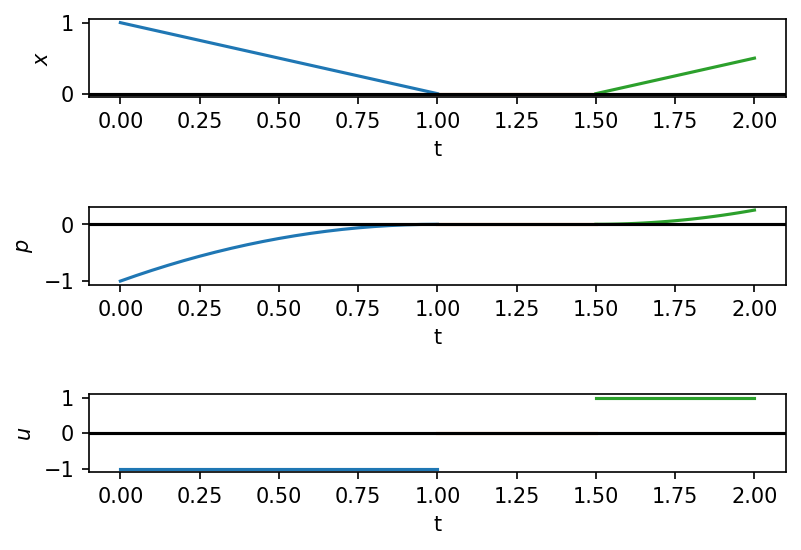

In [24]:
# plot solution
p0 = sol_nle_mul.x[0]
t1 = sol_nle_mul.x[1]
t2 = sol_nle_mul.x[2]
plotSolutionBSB(p0, t1, t2, tf)